# ex4 反向传播神经网络
包含吴恩达机器学习ex4的python实现，主要知识点为反向传播神经网络
参考： https://www.heywhale.com/mw/project/5da6bd34c83fb40042068a41

# 1. 神经网络
对于这个练习，我们将再次处理手写数字数据集，这次将使用反向传播的前馈神经网络，自动学习神经网络的参数。


## 1.1 数据可视化
这部分和ex3一样的，5000张20*20像素的手写数字数据集，以及对应的数字(1-9,0对应10)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
import scipy.optimize as opt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report#这个包是评价报告


In [4]:
data = loadmat('./Andrew-NG-Meachine-Learning/machine-learning-ex4/ex4/ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [5]:
# 得到X和y
X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

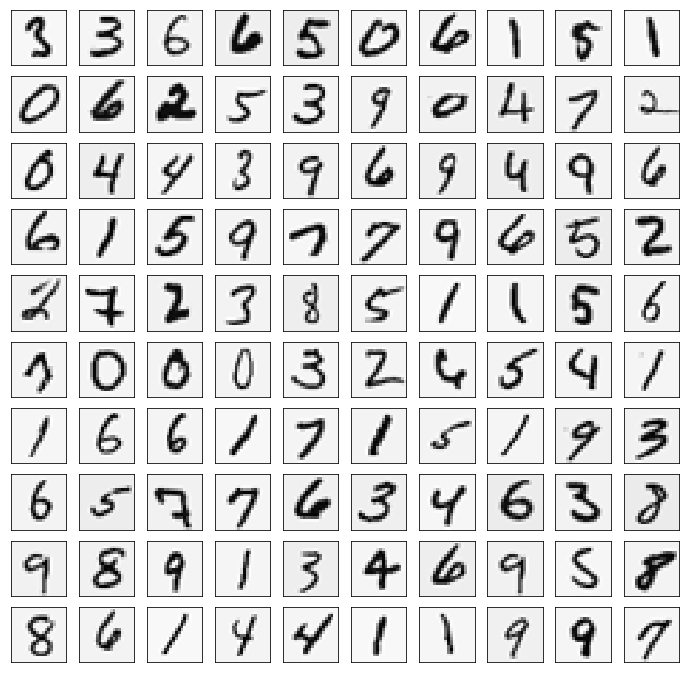

In [6]:
# 模型展示
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100)
sample_images = data['X'][sample_idx, :]
fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(12, 12))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(sample_images[10 * r + c].reshape((20, 20))).T,cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

## 1.2 模型展示
略

## 1.3 前向传播和代价函数
首先，实现神经网络的代价函数和梯度函数

要求：你的代码应该适用于任何数据集，包括任意数量的输入输出单元

## 实现序列化和反序列化的函数
因为后续使用Scipy来计算theta，需要的theta是一维的。

In [7]:
# 序列化
def serialize(a, b):
    """"
    序列化这两个矩阵。
    a: theta1 (25, 401) 
    b: theta2 (10, 26)
    """
    return np.concatenate((np.ravel(a), np.ravel(b)))
    # 反序列化 
def deserialize(seq):
    """
    将这个seq反序列化为(25, 401), (10,26)
    """
    return seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)

In [8]:
# sigmoid 
def sigmoid(z): 
    return 1 / (1 + np.exp(-z))

In [9]:
# forward_propagation
def forward_propagate(X, theta1, theta2):
    """
    X： (m, n) -> (m, n + 1) -> T (n + 1, m)
    theta1: (n1 , n + 1) ((25, 401)
    theta2: (n2, n1 + 1) (10, 26))
    """
    # 转置 -> 向量化计算 （400,5000)
    a0 = X.T #(n, m)
    # 插入一行
    a0 = np.insert(a0, 0, values=np.ones(a0.shape[1]), axis=0) # 第一行插入1， （n + 1, m) (401, 5000)
  
    # 计算a1
    assert(theta1.shape[1] == a0.shape[0])
    z1 = np.dot(theta1, a0) # (n1, n + 1) * (n + 1, m) -> (n1, m)  (25, 401) dot ( 401, 5000) -> (25, 5000)
    a1 = sigmoid(z1)
    
    # 插入一行
    a1 = np.insert(a1, 0, values=np.ones(a1.shape[1]), axis=0) # 第一行插入1， （n + 1, m) (26, 5000)
    # 计算a2
    assert(theta2.shape[1] == a1.shape[0])
    z2 = np.dot(theta2, a1) # (n2, n1 + 1) * (n1 + 1, m) -> (n2, m) (10, 26) dot (26, 5000) -> (10, 5000)
    h = sigmoid(z2) 
    return a0, z1, a1, z2, h #(401, 5000), z1(25, 5000) a1(26, 5000), z2(10, 5000), a2(10, 5000)

### 逻辑回归的代价函数
$$
        J(\theta) = \frac{1}{m} \sum_{i = 1}^{m} \left[-y^{(i)}log\left(h_\theta(x^{(i)})\right) - 
        \left(1 - y^{(i)}\right)log\left(1 - h_\theta(x^{(i)}\right)  \right] + 
        \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2
$$
### 神经网络的代价函数
$$
    J(\theta) = - \frac{1}{m} \left[\sum_{i = 1}^{m}\sum_{k= 1}^{K}y_k^{(i)} log(h_\theta(x^{(i)}))_k + (1 - y_k^{(i)})log(1- h_\theta(x^{(i)}))_k \right] + \frac{\lambda}{2m}\sum_{l = 1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}(\theta_{ji}^{(l)})^2
$$
其中，最后一层的输出单元个数为K。
$$
    h_\theta(x) \in R^K ,  (h_\theta(x))_i = i^{th} output
$$
对这个公式进行理解， 外面肯定有m个数据，对于每一个数据，计算最后一层的K的结点的损失函数和。
正则化其实就是加上所有的$\theta$

In [10]:
# cost 这里没有计算正则化
def cost(theta1, theta2, X, y): 
    """
    theta1: (n1 , n + 1)   n1: 隐藏层1的结点个数  n: X的n
    theta2: (n2, n1 + 1)   n2: 输出层的结点个数  10
    X： (m, n) (5000, 400)
    y:  (m, n2) 本来y是(m, 1)然后经过onehot->(m, n2) 这里指的是(5000, 10)
    """
    # forward 过程： (n2, n1 + 1（补充）) * (n1 + 1(补充), n + 1) * (n + 1, m)  -> (n2, m)
    _, _, _, _, h = forward_propagate(X, theta1, theta2) # h: (n2, m) (10, 5000)
    # 计算里面的数
    # 转置后可以进行向量化计算 (5000,10) -> (10, 5000)
    y = y.T
    pair_computation = np.multiply(-y, np.log(h)) + np.multiply(-(1-y), np.log(1-h)) 
    # 保证维度
    assert(X.shape[0] == h.shape[1])
    m = h.shape[1]
    return pair_computation.sum() / m

**对y标签进行编码**

一开始我们得到的y的纬度为（5000，1），然后我们要把他编码成5000*10的矩阵。
比如说， $y_0 = 2$， 转化后的y为 [0, 1, 0, ..., 0] (10, ) 

Scikitlearn有一个内置的编码函数，我们进行调用

In [11]:
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [12]:
y = np.array(y_onehot)
y.shape

(5000, 10)

In [13]:
weight = loadmat("./Andrew-NG-Meachine-Learning/machine-learning-ex4/ex4/ex4weights.mat")
theta1, theta2 = weight['Theta1'], weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [14]:
# 验证cost， 0.287
cost(theta1, theta2, X, y)


0.28762916516131887

In [15]:
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [16]:
# coseReg
def costReg(theta, X, y, lambd): 
    """
    theta反序列化为theta1,theta2 
    theta1: (n1 , n + 1)   n1: 隐藏层1的结点个数  n: X的n
    theta2: (n2, n1 + 1)   n2: 输出层的结点个数  10
    X： (m, n) (5000, 400)
    y:  (m, n2) 本来y是(m, 1)然后经过onehot->(m, n2) 这里指的是(5000, 10)
    lambd: 正则L2的参数 
    """
    theta1, theta2 = deserialize(theta)
    m = X.shape[0]
    cos = cost(theta1, theta2, X, y)
    reg = np.power(theta1[:, 1:], 2).sum() + np.power(theta2[:, 1:], 2).sum()
    reg *= lambd / (2 * m)
    return cos + reg

In [17]:
costReg(serialize(theta1, theta2), X, y, 1)

0.3837698590909236

In [18]:
np.arange(9).reshape(3,3).flatten()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

# 2 反向传播
这一部分需要实现反向传播的算法，来计算神经网络代价函数的梯度，获得了梯度的数据，我们就可以使用工具库来计算代价函数的最小值。

## 2.1 sigmoid梯度
你需要实现sigomid的梯度，公式如下：
$$
    g'(z) = \frac{d}{dz}g(z) = g(z)(1 - g(z))
$$
其中
$$
    sigmoid(z) = g(z) = \frac{1}{1 + e^{-z}}
$$
在绝对值比较大的数上，梯度应该接近0，当z=0时候，梯度为0.25
另外，这个函数应该可以作用于向量以及矩阵，作用在矩阵上时，应该是计算每个元素的梯度。

## 2.2 随机初始
当我们训练神经网络的时候，需要将 $\theta^{(l)}$设定为$ \left(-\varepsilon_{init},\varepsilon_{init}\right) $ 之间的随机值，此处我们设定 $\varepsilon = 0.12$ 

In [19]:
# sigmoid 求导
def sigmoid_derivation(z):
    """
    pairwise op is key for this to work on both vector and matrix
    """
    return np.multiply(sigmoid(z), 1 - sigmoid(z))


In [20]:
sigmoid_derivation(0)

0.25

In [21]:
# gradient
def gradient(theta1, theta2, X, y):
    """
    输出层 n0 : 400
    隐藏层 n1 : 25 
    输出层 n2 : 10
    theta1: (n1, n0 + 1) -> (25, 400 + 1) -> (25, 401) 
    theta2: (n2, n1 + 1) -> (10, 25 + 1) -> (10, 26)
    X: (m, n)  (5000, 400)
    y: (m, n2) (5000, 10)
    lambd: float
    """
    m = len(X)
    # 前向传播计算  #a0(401, 5000), z1(25, 5000) a1(26, 5000), z2(10, 5000), h(10, 5000)
    a0, z1, a1, z2, h = forward_propagate(X, theta1, theta2)
    y = y.T
    assert(h.shape == y.shape)
    # 计算梯度
    dZ2 = h - y # (10, 5000)
    print("dZ2 shape: ", dZ2.shape)
    # dW2 = dZ2 dot a1.T  
    # dZ2 (10, 5000) dot (5000, 26)
    dW2 = (dZ2.dot(a1.T)) / m
    assert(dW2.shape == theta2.shape)
    print("dW2 shape:", dW2.shape)
    # dZ1 = da1 multiply g'(z1) = (W[2]^T dot dz2) multiply g'(z1)
    # W[2] (10, 26) W[2]T = (26, 10) dot (10, 5000) -> (26, 5000) multiply (z1) (25, 5000) 
    # So, z1 应该增加一行，不然计算会出错 
    # change z1 (25, 5000) -> (26, 5000) 
    # 然后可以计算出dZ1: (26, 5000)
    z1 = np.insert(z1, 0, np.ones(z1.shape[1]), axis = 0)
    dZ1 = np.multiply(np.dot(theta2.T, dZ2), sigmoid_derivation(z1))
    print("dZ1 shape:", dZ1.shape)
    # dW1 = dZ1 dot a0.T 
    # 错误： dZ1(26, 5000) dot (5000, 401) -> (26, 401) 
    # 因为多出来的那个参数是不需要进行梯度下降的，所以应该从第1行往下面取 
    # 因此公式更新为： dZ1[1:, :] dot a0.T
    dW1 = (dZ1[1:,:].dot(a0.T)) / m
    # assert(dW1.shape == theta1.shape)
    print("dW1 shape:", dW1.shape)
    return dW1, dW2

In [22]:
dW1, dW2 = gradient(theta1, theta2, X, y)
dW1.shape, dW2.shape

dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)


((25, 401), (10, 26))

In [23]:
weight = loadmat("./Andrew-NG-Meachine-Learning/machine-learning-ex4/ex4/ex4weights.mat")
theta1, theta2 = weight['Theta1'], weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [24]:
serialize(dW1, dW2).shape

(10285,)

In [25]:
dW1, dW2 = deserialize(serialize(dW1, dW2))
dW1.shape, dW2.shape

((25, 401), (10, 26))

# 正则化梯度下降
正则化梯度下降需要加上
$$
    \frac{\lambda}{m}\theta_{ij}^{l}， 对于j>=1的
$$

In [26]:
def gradientReg(theta, X, y, lambd):
    """
    theta: (10285,) -> theta1, theta2
    X: (m, n0)
    y: (m, 10)
    lambda: float
    """
    m = X.shape[0]
    theta1, theta2 = deserialize(theta)
    # 计算梯度(25, 401), (20,26)
    grad1, grad2 = gradient(theta1, theta2, X, y)
    print(grad1.shape, grad2.shape)
    # 计算正则项
    # 令第一列为0
    theta1[:, 0] = 0
    reg_term_1 = (lambd / m) * theta1
    grad1 += reg_term_1
    # 令第一列为0
    theta2[:, 0] = 0
    reg_term_2 = (lambd / m) * theta2
    grad2 += reg_term_2

    return serialize(grad1, grad2)

In [27]:
def random_init(size): 
    return np.random.uniform(-0.12, 0.12, size)

In [28]:
init_theta = random_init(25*401 + 10 * 26)
init_theta.shape

(10285,)

In [29]:
gradientReg(init_theta,X, y, 1)


dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)


array([-2.58595183e-03, -5.98277513e-06,  1.20352263e-05, ...,
        2.71273744e-01,  2.21915162e-01,  2.30714177e-01])

In [30]:
fmin = opt.minimize(fun=costReg, x0=init_theta, args=(X, y, 1), method='TNC', jac=gradientReg,
                       options={'maxiter': 500})
fmin                     

dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)
dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)
dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)
dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)
dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)
dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)
dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)
dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)
dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (26, 5000)
dW1 shape: (25, 401)
(25, 401) (10, 26)
dZ2 shape:  (10, 5000)
dW2 shape: (10, 26)
dZ1 shape: (

     fun: 0.3114372622210825
     jac: array([ 3.87208206e-05,  8.82366727e-09, -1.62013944e-08, ...,
        2.72209905e-06,  2.28943118e-05,  6.60632017e-06])
 message: 'Max. number of function evaluations reached'
    nfev: 500
     nit: 30
  status: 3
 success: False
       x: array([-1.82509754e+00,  4.41183364e-05, -8.10069722e-05, ...,
       -1.53532029e+00,  1.42327515e-01, -7.65922155e-01])

In [31]:
theta1, theta2 = deserialize(fmin.x)
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [32]:
_, _, _, _, h = forward_propagate(X, theta1, theta2)
print(h.shape)
y_pred = np.array(np.argmax(h, axis = 0) + 1)
y_pred

(10, 5000)


array([10, 10, 10, ...,  9,  9,  9])

In [33]:
print(classification_report(data['y'], y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       500
           2       1.00      1.00      1.00       500
           3       1.00      0.99      0.99       500
           4       1.00      0.99      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      0.99      0.99       500
           8       1.00      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       1.00      1.00      1.00       500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



# 3. 可视化隐藏层


In [35]:
hidden_layer = theta1[:, 1:] 
hidden_layer.shape

(25, 400)

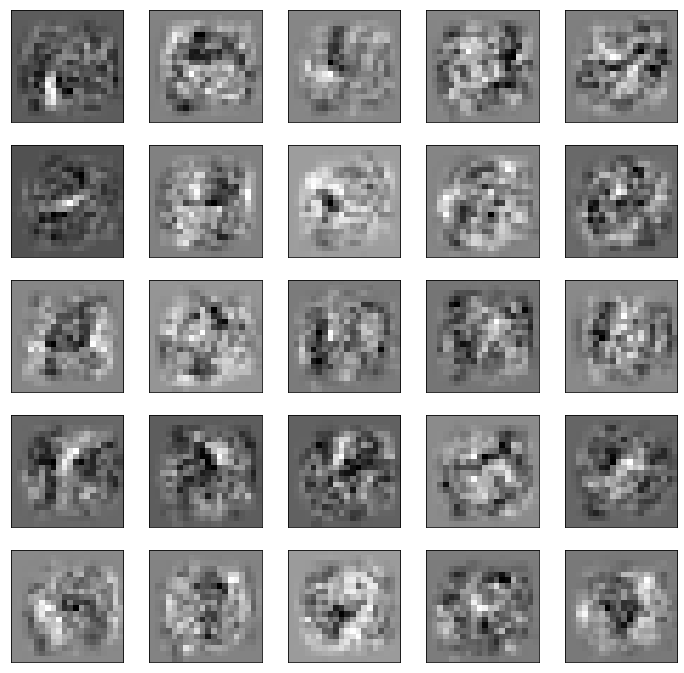

In [36]:
fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(12, 12))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(hidden_layer[5 * r + c].reshape((20, 20))), cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 